# Symulator tomografu komputerowego

Mikołaj Kiszka 155973 <br>
Maja Komorowska 155844

Poniżej opisane są fragmenty kodu zastosowane do stworzenia symulatora tomografu komputerowego. Do interaktywnego interfejsu można przejść [tutaj](#aplikacja-interaktywna)

### Symulator tomografu komputerowego wykanany został w Pythonie
Wykorzystane biblioteki:

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
import pydicom
from pydicom.dataset import Dataset
import ipywidgets as widgets
from IPython.display import display
import datetime
import random

FULL_SCAN_ANGLE = 360.0
global singoram_steps
singoram_steps = []
global radon_steps
radon_steps = []

### Odczyt plików jpg i dicom

In [4]:
def cutThirdDimension(bitmap):
    if bitmap.ndim == 3:
        return bitmap[..., 0]
    else:
        return bitmap

def scaleBitmap(bitmap):
    return bitmap/255.0

def turnSingleJpgIntoBitmap(single_file):
    directory = r"Tomograf-images"
    jpg_file = os.path.join(directory, single_file)
    if single_file.lower().endswith('.jpg'):
        img = Image.open(jpg_file)
        bitmap = np.array(img)
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()

def turnSingleDicomIntoBitmap(single_file):
    directory = r"Tomograf-dicom"
    dicom_file = os.path.join(directory, single_file)

    if single_file.lower().endswith('.dcm'):
        dicom_data = pydicom.dcmread(dicom_file)
        bitmap = dicom_data.pixel_array.astype(np.float32)  # Convert to float for stability
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()
    

### Obsługa zapisu plików do foramtów jpg i dicom

In [7]:
def saveBitmapAsJpg(bitmap, filename):
    img = Image.fromarray((bitmap * 255).astype(np.uint8))  # Normalize to 0-255 range
    img.save(filename, format="JPEG")

def saveBitmapAsDicom(bitmap, filename, patient_name, patient_id, date, comment="Generated DICOM image"):
    ds = Dataset()

    # Set required DICOM fields (some set to static or random values)
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.Modality = "CT"
    ds.StudyDate = datetime.datetime.strptime(date, "%d.%m.%Y")
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = pydicom.uid.CTImageStorage
    ds.ImageType = ["ORIGINAL", "PRIMARY", "AXIAL"]
    ds.InstanceNumber = str(random.randint(1, 100))
    ds.ImagesInAcquisition = "1"
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    # Convert bitmap to DICOM pixel array
    ds.Rows, ds.Columns = bitmap.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = (bitmap.astype(np.uint16)).tobytes()

    # Set DICOM file meta information
    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = pydicom.uid.generate_uid()
    file_meta.ImplementationVersionName = "PYDICOM 2.0.0"

    ds.file_meta = file_meta

    ds.ImageComments = comment

    # Save as DICOM file
    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.save_as(filename, write_like_original=False)

### Algorytm Brehensama
Zastosowany do symulacji promieni od emiterów do detektorów

In [8]:
def bresenhamAlgorithm(x1, y1, x2, y2):
    points = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Direction of the algorithm
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1

    # First pixel
    points.append((x,y))

    if dx > dy:
        # Algorithm operates on the leading axis OX
        
        d = 2*dy - dx
        while x != x2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dy-dx)
            else:
                # Move horizzontally
                d += 2*dy
                x += xi
            points.append((x,y))
    else:
        # Algorithm operates on the leading axis OY

        d = 2*dx - dy
        while y != y2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dx-dy)
            else:
                # Move vertically
                d += 2*dx
                y += yi
            points.append((x,y))
    return points

### Funkcja rozszerzająca obrazy prostokątne do kwadratowych
Piksele poza oryginalnym obrazem wypełnione zerami

In [9]:
def resizeImage(bitmap):
    # Get the dimensions of the input bitmap (rectangle)
    a, b = bitmap.shape

    # If already square just return unchanged
    if a == b:
        return bitmap
    
    size = max(a, b)

    # Create a bitmap with the desired dimensions
    big_bitmap = np.zeros((size, size), dtype=bitmap.dtype)

    # Compute the offsets to center the image
    start_x = (size - a) // 2
    start_y = (size - b) // 2

    # Copy the original bitmap into the center of the new bitmap
    big_bitmap[start_x:start_x + a, start_y:start_y + b] = bitmap

    return big_bitmap

### Transformata Radona
Zastosowany model stożkowy z symulacją ruchu emitera i detektorów

In [ ]:
def radonTransform(bitmap , step, detectors_span, detectors_number):
    bitmap = resizeImage(bitmap)

    size = max(bitmap.shape)
    center = size//2
    radius = size//2 - 1

    angles = np.deg2rad(np.arange(0,FULL_SCAN_ANGLE,step))
    span_rad = np.deg2rad(detectors_span)

    sinogram = np.zeros((len(angles), detectors_number), dtype=bitmap.dtype)

    for a_i, angle in enumerate(angles):
        # Emitter coordinates
        x = int(center + radius*np.cos(angle))
        y = int(center + radius*np.sin(angle))

        # Calculate detectors placements for each emiiter 
        for d_i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*np.cos(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*np.sin(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)
            
            # Calculate sinogram single point
            total_intensity = np.mean([bitmap[x_b, y_b] for x_b, y_b in bresenham_points if 0 <= x < size and 0 <= y < size])
            sinogram[a_i, d_i] = total_intensity
            singoram_steps.append(sinogram)
    return sinogram, bitmap.shape[0]

### Filtrowanie
Zastosowana konwolucja z domyślą maską (jądrem) 21

In [11]:
def filtering(bitmap, kernel_size = 21):
    # Ensure that the kernel size is odd
    if kernel_size%2==0:
        kernel_size += 1
    kernel = np.zeros(kernel_size)	

    # Calculate middle index (kernel is indexed from -k to k są the middle index is k=0)
    middle_idx = kernel_size//2
    kernel[middle_idx] = 1

    # Calculate kernel values for negative k:
    # h[k] = 0, if k is even
    # h[k] = (-4/pi^2)/k^2, if k is odd
    for i in range(1, middle_idx, 2):
        kernel[i] = (-4/(np.pi**2)) / ((i-middle_idx)**2) 

    # Mirror first half of kernel into the second half
    kernel[-middle_idx:] = kernel[:middle_idx][::-1]

    # Use convolution
    for it, i in enumerate(bitmap):
        bitmap[it] = np.convolve(i, kernel, mode='same')
    return bitmap

### Odwrotna transformata Radona
Wykonana analogicznie do transformaty Radona i pozwala na wstępne odtworzenie obrazu oryginalnego

In [12]:
def inverseRadonTransform(sinogram, resized_size, detectors_span):
    step = FULL_SCAN_ANGLE/sinogram.shape[0]
    detectors_number = sinogram.shape[1]

    center = resized_size//2
    radius = resized_size//2 - 1

    angles = np.deg2rad(np.arange(0,FULL_SCAN_ANGLE,step))
    span_rad = np.deg2rad(detectors_span)

    result_image = np.zeros((resized_size, resized_size), dtype=sinogram.dtype)

    for a_i, angle in enumerate(angles):
        # Emitter coordinates
        x = int(center + radius*np.cos(angle))
        y = int(center + radius*np.sin(angle))

        for d_i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*np.cos(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*np.sin(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)

            # Calculate sinogram single point
            for x_b, y_b in bresenham_points:
                if 0 <= x_b < resized_size and 0 <= y_b < resized_size:
                    result_image[x_b, y_b] += sinogram[a_i, d_i]
    return result_image

### Przywrócenie oryginalnego rozmiaru obrazu

In [13]:
def cropToOriginal(resized_bitmap, a, b):
    size = resized_bitmap.shape[0]  # Square size

    # Compute the offsets used during centering
    start_x = (size - a) // 2
    start_y = (size - b) // 2

    # Crop the image back to the original size
    cropped_bitmap = resized_bitmap[start_x:start_x + a, start_y:start_y + b]

    return cropped_bitmap

### Normalizacja obrazu wynikowego
Usunięcie ujemnych wartości i przeskalowanie go do zakresu [0,1] na podstawie 99.9. percentyla wartości pikseli

In [14]:
def normalizeImage(bitmap):
    bitmap = np.maximum(bitmap, 0)  # Remove negative values
    max_val = np.quantile(bitmap, 0.999)  # Use the 99.9th percentile for scaling
    bitmap = np.clip(bitmap / max_val, 0, 1) if max_val > 0 else np.zeros_like(bitmap)
    return bitmap

### Obliczenie błędu średniokwadratowego

In [15]:
def rootMeanSquaredError(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError("Obrazy muszą mieć ten sam rozmiar")
    
    # Obliczanie RMSE
    rmse = (np.mean((img1 - img2) ** 2))**0.5
    return rmse

### Przykłady działania symulatora

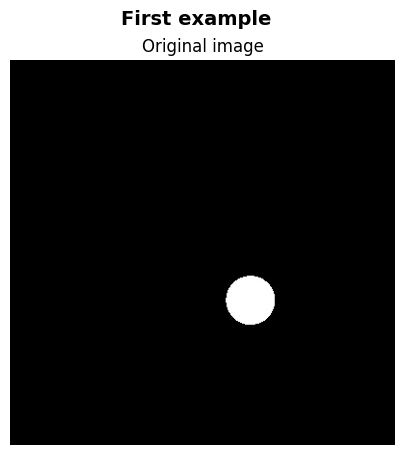

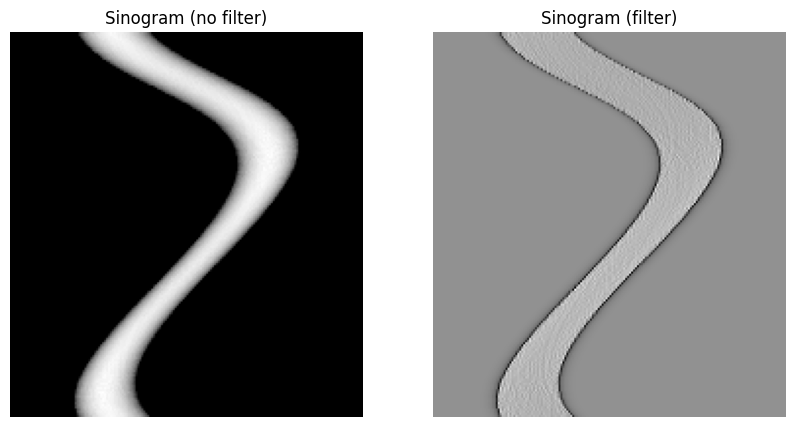

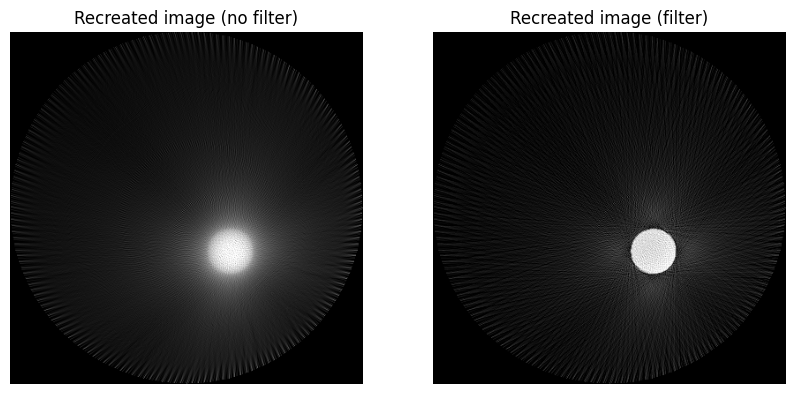

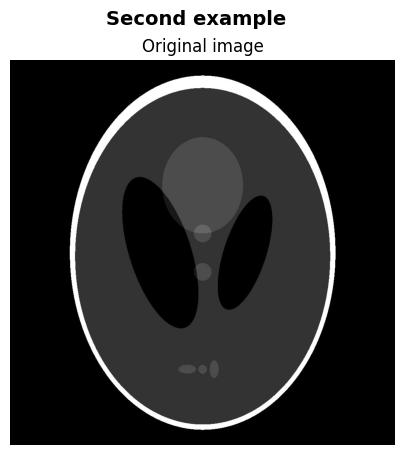

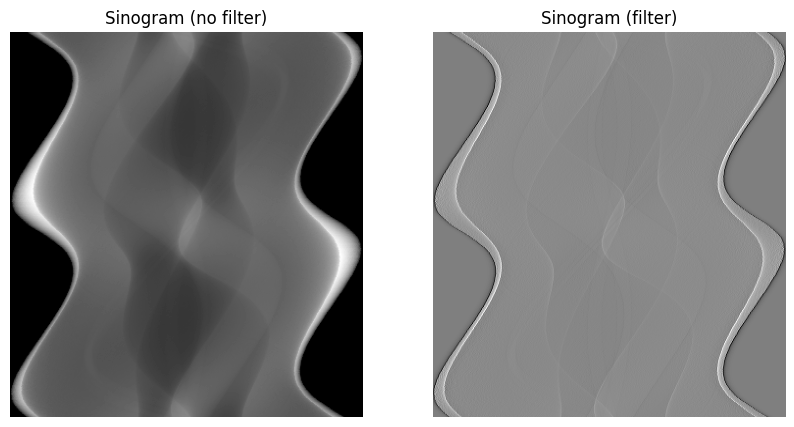

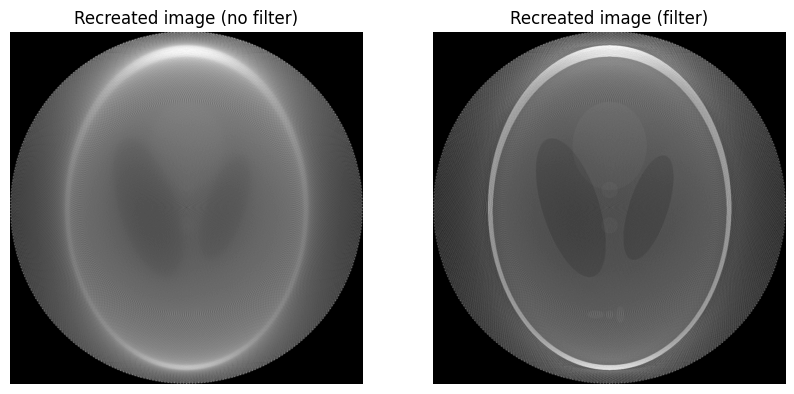

In [264]:
# First example
# Simple jpg to jpg

bitmap = turnSingleJpgIntoBitmap('Kropka.jpg')
original_shape_a = bitmap.shape[0]
original_shape_b = bitmap.shape[1]

step = 2
detectors_span = 180
detectors_number = 180

sinogram, resized_shape = radonTransform(bitmap, step, detectors_span, detectors_number)

inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span)
inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

sinogram_cp = sinogram.copy()
sinogram_filtered = filtering(sinogram_cp, 21)

inversed_bitmap_filtered = inverseRadonTransform(sinogram_filtered, resized_shape, detectors_span)
inversed_bitmap_filtered = cropToOriginal(inversed_bitmap_filtered, original_shape_a, original_shape_b)
normalized_inversed_bitmap_filtered = normalizeImage(inversed_bitmap_filtered)

plt.figure(figsize=(5, 5))
plt.suptitle("First example", fontsize=14, fontweight='bold')
plt.imshow(bitmap, cmap='gray')
plt.title("Original image")
plt.axis("off")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sinogram, cmap='gray', aspect='auto')
axes[0].set_title("Sinogram (no filter)")
axes[0].axis("off")

axes[1].imshow(sinogram_filtered, cmap='gray', aspect='auto')
axes[1].set_title("Sinogram (filter)")
axes[1].axis("off")

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(normalized_inversed_bitmap, cmap='gray')
axes[0].set_title("Recreated image (no filter)")
axes[0].axis("off")

axes[1].imshow(normalized_inversed_bitmap_filtered, cmap='gray')
axes[1].set_title("Recreated image (filter)")
axes[1].axis("off")

plt.show()

saveBitmapAsJpg(normalized_inversed_bitmap, "example1_nofilter.jpg")
saveBitmapAsJpg(normalized_inversed_bitmap_filtered, "example1_filter.jpg")

# Second example
# More complicated dicom to dicom
bitmap = turnSingleDicomIntoBitmap('shepp_logan.dcm')
original_shape_a = bitmap.shape[0]
original_shape_b = bitmap.shape[1]

step = 1
detectors_span = 270
detectors_number = 360

sinogram, resized_shape = radonTransform(bitmap, step, detectors_span, detectors_number)

inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span)
inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

sinogram_cp = sinogram.copy()
sinogram_filtered = filtering(sinogram_cp, 21)

inversed_bitmap_filtered = inverseRadonTransform(sinogram_filtered, resized_shape, detectors_span)
inversed_bitmap_filtered = cropToOriginal(inversed_bitmap_filtered, original_shape_a, original_shape_b)
normalized_inversed_bitmap_filtered = normalizeImage(inversed_bitmap_filtered)

plt.figure(figsize=(5, 5))
plt.suptitle("Second example", fontsize=14, fontweight='bold')
plt.imshow(bitmap, cmap='gray')
plt.title("Original image")
plt.axis("off")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sinogram, cmap='gray', aspect='auto')
axes[0].set_title("Sinogram (no filter)")
axes[0].axis("off")

axes[1].imshow(sinogram_filtered, cmap='gray', aspect='auto')
axes[1].set_title("Sinogram (filter)")
axes[1].axis("off")

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(normalized_inversed_bitmap, cmap='gray')
axes[0].set_title("Recreated image (no filter)")
axes[0].axis("off")

axes[1].imshow(normalized_inversed_bitmap_filtered, cmap='gray')
axes[1].set_title("Recreated image (filter)")
axes[1].axis("off")

plt.show()

saveBitmapAsDicom((normalized_inversed_bitmap * 65535).astype(np.uint16), "example2_nofilter.dcm", "Stefan Batory", "1122334455", "15.01.2025", "No filter")
saveBitmapAsDicom((normalized_inversed_bitmap_filtered * 65535).astype(np.uint16), "example2_filter.dcm", "Stefan Batory", "6677889900", "15.01.2025", "Filter")

### Badanie wpływu poszczególnych parametrów na jakoś obrazu wynikowego
* Liczba detektorów
* Liczba skanów
* Rozpiętość wachlarza
* Filtrowanie

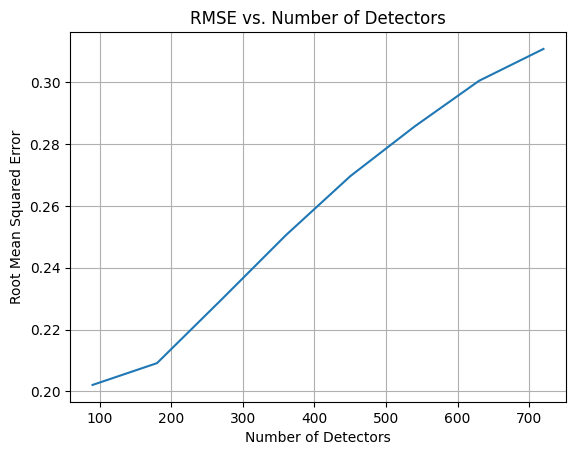

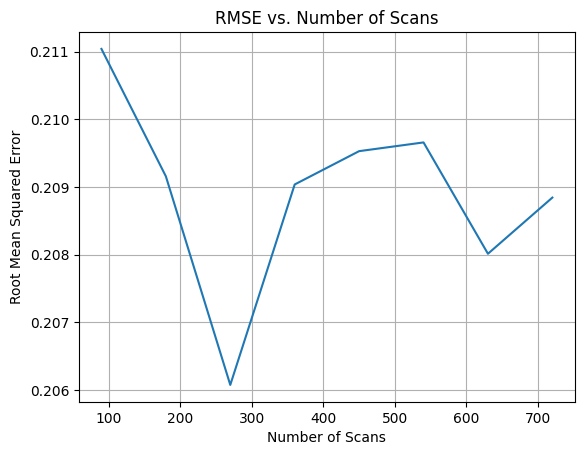

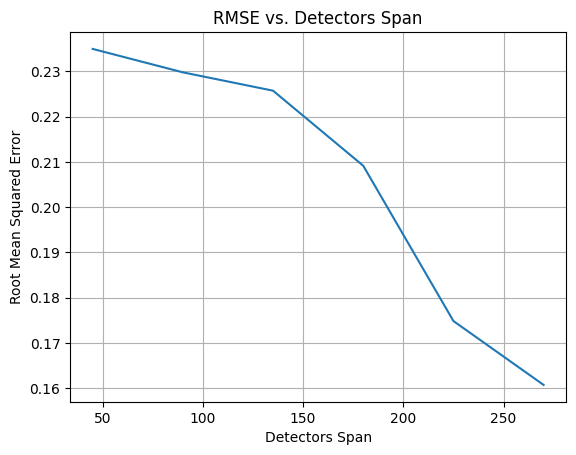

Simple image filter influence
RMSE without filter: 0.3229776435111086, RMSE with filter: 0.30205610031935326

Complex image filter influence
RMSE without filter: 0.2918063436705631, RMSE with filter: 0.22675962751320947



In [277]:
bitmap = turnSingleDicomIntoBitmap('shepp_logan.dcm')
original_shape_a = bitmap.shape[0]
original_shape_b = bitmap.shape[1]

default_scans_number = 180
default_step = FULL_SCAN_ANGLE/default_scans_number
default_detectors_span = 180
default_detectors_number = 180

# RMSE for different numbers of detectors

detectors_range = range(90, 721, 90)
rmse_detectors = []

for detectors_number in detectors_range:
    sinogram, resized_shape = radonTransform(bitmap, default_step, default_detectors_span, detectors_number)

    sinogram = filtering(sinogram, 21)

    inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, default_detectors_span)
    inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
    normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

    rmse_detectors.append(rootMeanSquaredError(bitmap, normalized_inversed_bitmap))

plt.plot(detectors_range, rmse_detectors)
plt.xlabel('Number of Detectors')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE vs. Number of Detectors')
plt.grid(True)
plt.show()

# RMSE for different numbers of scans

scans_range = range(90, 721, 90)
rmse_scans = []

for scans_number in scans_range:
    step = FULL_SCAN_ANGLE/scans_number

    sinogram, resized_shape = radonTransform(bitmap, step, default_detectors_span, default_detectors_number)

    sinogram = filtering(sinogram, 21)

    inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, default_detectors_span)
    inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
    normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

    rmse_scans.append(rootMeanSquaredError(bitmap, normalized_inversed_bitmap))

plt.plot(scans_range, rmse_scans)
plt.xlabel('Number of Scans')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE vs. Number of Scans')
plt.grid(True)
plt.show()

# RMSE for different detectors spans

span_range = range(45, 271, 45)
rmse_span = []

for span in span_range:
    sinogram, resized_shape = radonTransform(bitmap, default_step, span, default_detectors_number)

    sinogram = filtering(sinogram, 21)

    inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, span)
    inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
    normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

    rmse_span.append(rootMeanSquaredError(bitmap, normalized_inversed_bitmap))

plt.plot(span_range, rmse_span)
plt.xlabel('Detectors Span')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE vs. Detectors Span')
plt.grid(True)
plt.show()


# Filter usage influance for simple image

bitmap = turnSingleDicomIntoBitmap('Kwadraty2.dcm')
original_shape_a = bitmap.shape[0]
original_shape_b = bitmap.shape[1]

step = 1
detectors_span = 270
detectors_number = 360

sinogram, resized_shape = radonTransform(bitmap, step, detectors_span, detectors_number)

inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span)
inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

sinogram_cp = sinogram.copy()
sinogram_filtered = filtering(sinogram_cp, 21)

inversed_bitmap_filtered = inverseRadonTransform(sinogram_filtered, resized_shape, detectors_span)
inversed_bitmap_filtered = cropToOriginal(inversed_bitmap_filtered, original_shape_a, original_shape_b)
normalized_inversed_bitmap_filtered = normalizeImage(inversed_bitmap_filtered)

rmse_no_filter = rootMeanSquaredError(bitmap, normalized_inversed_bitmap)
rmse_filter = rootMeanSquaredError(bitmap, normalized_inversed_bitmap_filtered)

print('Simple image filter influence')
print(f'RMSE without filter: {rmse_no_filter}, RMSE with filter: {rmse_filter}\n')

# Filter usage influance for complex image

bitmap = turnSingleDicomIntoBitmap('shepp_logan.dcm')
original_shape_a = bitmap.shape[0]
original_shape_b = bitmap.shape[1]

step = 1
detectors_span = 270
detectors_number = 360

sinogram, resized_shape = radonTransform(bitmap, step, detectors_span, detectors_number)

inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span)
inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
normalized_inversed_bitmap = normalizeImage(inversed_bitmap)

sinogram_cp = sinogram.copy()
sinogram_filtered = filtering(sinogram_cp, 21)

inversed_bitmap_filtered = inverseRadonTransform(sinogram_filtered, resized_shape, detectors_span)
inversed_bitmap_filtered = cropToOriginal(inversed_bitmap_filtered, original_shape_a, original_shape_b)
normalized_inversed_bitmap_filtered = normalizeImage(inversed_bitmap_filtered)

rmse_no_filter = rootMeanSquaredError(bitmap, normalized_inversed_bitmap)
rmse_filter = rootMeanSquaredError(bitmap, normalized_inversed_bitmap_filtered)

print('Complex image filter influence')
print(f'RMSE without filter: {rmse_no_filter}, RMSE with filter: {rmse_filter}\n')


* Liczba detektorów <br>
Obliczenia RMSE zgadzają się z subiektywną oceną obrazu. Zwiększanie liczby detektorów powoduje coraz mocniejsze rozświetlenie obrazu i coraz widoczniejsze stają się promienie dookoła oryginalnego obrazu. Zmiana obróbki finalnego obrazu mogłaby pomóc z tym problemem, jednak przy obecnej implementacji lepiej sprawdzają się mniejsze liczby detektorów (do minimalnej wartości 90, gdyż poniżej tej wartości obrazy stają się już niewyraźne).

* Liczba skanów <br>
Subiektywnie obrazy są bardzo zbliżone do siebie (poza wyraźnie gorszym obrazem dla minimalnej liczby skanów - 90). Ciężko więc zobaczyć zależność RMSE wynikającą z obliczeń.

* Rozpiętość wachlarza <br>
Zwiększanie rozpiętości wachlarza wyraźnie poprawia jakość wynikowego obrazu. Przy wartościach poniżej 180 nie widać nawet wszystkich szczegółów obrazu. Obserwacje te są zgodne z obliczonymi wartościami RMSE.

* Filtracja <br>
Filtrowanie obrazu wyraźnie poprawia jakość wynikowego obrazu. Dla prostych obrazów brak filtracji powoduje, że obraz staje się nieostry. Dla bardziej skomplikowanych obrazów, jeżeli nie zastosowano filtracji, to obraz staje się bardzo niewyraźny. Obserwacje te są zgodne z obliczonymi wartościami RMSE

### Deklaracja interfejsu do obsługi symolatora tomografu komputerowego

### Aplikacja interaktywna

In [ ]:
if __name__ == '__main__':
    
    
    #For multiple files turning into bitmaps
    # bitmap_files = turnJpgIntoBitmap(r"Tomograf-images")
    # for file in bitmap_files:
    #     plt.imshow(file, cmap='gray')
    #     plt.show()

    #Single file into bitmap
    # bitmap = turnSingleJpgIntoBitmap('Shepp_logan.jpg')

    #Single dicom file into bitmap



HTML(value='<p><b>   Provide the name of the DICOM input file   </b></p>')

Text(value='', layout=Layout(margin='20px', width='600px'), placeholder='Type the name of the input file')

HTML(value='No file selected yet')

KeyboardInterrupt: 

In [ ]:
def main(data):
    bitmap = turnSingleDicomIntoBitmap(data["input_file"])

    original_shape_a = bitmap.shape[0]
    original_shape_b = bitmap.shape[1]

    plt.imshow(bitmap, cmap='gray')
    plt.show()

    
    sinogram, resized_shape = radonTransform(bitmap=bitmap, step=data["step"], detectors_span=data["divergence"], detectors_number=data["num_detectors"])
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.show()

    print(data["use_filtering"])
    if data["use_filtering"]:
        sinogram = filtering(sinogram, 21)
        plt.imshow(sinogram, cmap='gray', aspect='auto')
        plt.show()
    
    inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span=data["divergence"])
    inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
    normalized_inversed_bitmap = normalizeImage(inversed_bitmap)
    plt.imshow(normalized_inversed_bitmap, cmap='gray')
    plt.show()

    # saveBitmapAsJpg(normalized_inversed_bitmap, "test.jpg")
    saveBitmapAsDicom((normalized_inversed_bitmap * 65535).astype(np.uint16), data["output_file"], data["patient_name"], data["patient_id"], data["date"], data["comment"])

    # rmse = rootMeanSquaredError(bitmap, normalized_inversed_bitmap)
    # print(f"Mean Squared Error: {rmse}")

HTML(value='<p><b>Provide technical parameters</b></p>')

FloatSlider(value=2.0, max=4.0, min=0.5, step=0.25)

HTML(value='<p><b>Number of detectors</b></p>')

IntSlider(value=180, max=720, min=90, step=90)

HTML(value='<p><b>Divergence/span</b></p>')

IntSlider(value=180, max=270, min=45, step=45)

HTML(value='<p><b>Show process</b></p>')

IntSlider(value=180, max=270, min=45, step=45)

HTML(value='<p><b>Provide the name of the DICOM input file</b></p>')

Text(value='', placeholder='Type the input file name')

HTML(value='<p><b>Provide DICOM file data</b></p>')

Text(value='Name Surname', placeholder='Patient Name')

Text(value='dd.mm.yyyy', placeholder='Date')

Text(value='Patient ID', placeholder='Patient ID')

Text(value='Comment', placeholder='Comment')

Text(value='Output File', placeholder='Output file name')

HTML(value='<p><b>Use filtering?</b></p>')

Checkbox(value=False, description='Use filtering')

Button(description='Submit', style=ButtonStyle())

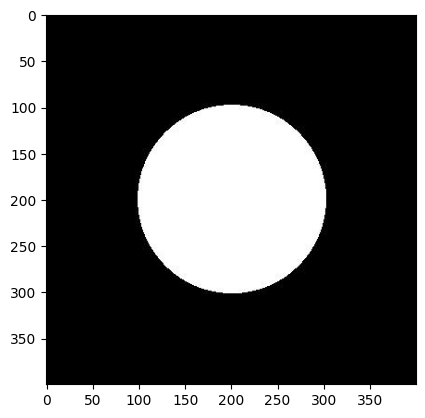

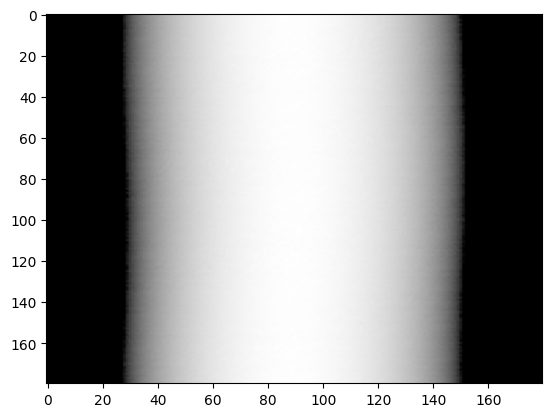

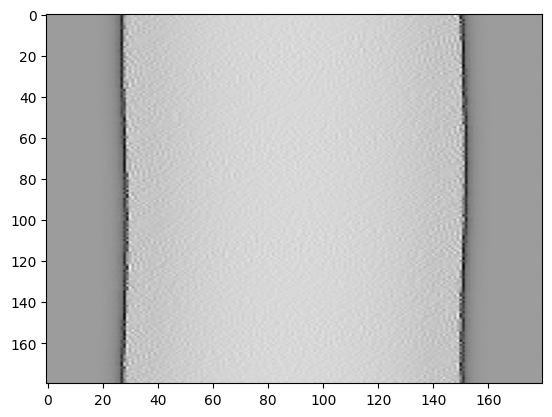

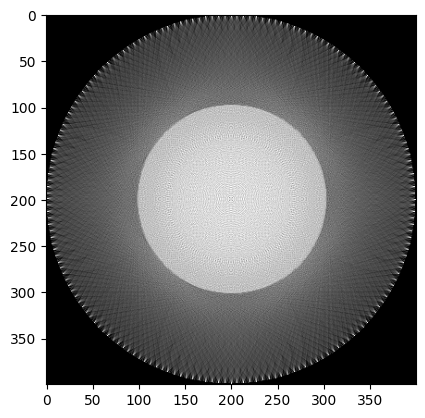

In [ ]:
output_widget = widgets.Output()
def process_data(data):
    with output_widget:
        output_widget.clear_output()
        print("Processing Data:", data)

def collect_data():
    data = {
        "step": widget_slider_step.value,
        "num_detectors": widget_slider_n.value,
        "divergence": widget_slider_span.value,
        "show_process": widget_slider_show_process.value,
        "input_file": text_widget_file.value,
        "patient_name": text_widget_patient_name.value,
        "date": text_widget_date.value,
        "patient_id": text_widget_patient_id.value,
        "comment": text_widget_comment.value,
        "output_file": text_widget_output_file.value,
        "use_filtering": filter_checkbox.value,
    }
    process_data(data)
    main(data)

def add_interactive_ui():
    global widget_slider_step, widget_slider_n, widget_slider_span, widget_slider_show_process
    global text_widget_file, text_widget_patient_name, text_widget_date
    global text_widget_patient_id, text_widget_comment, text_widget_output_file, filter_checkbox

    display(widgets.HTML(value="<p><b>Provide technical parameters</b></p>"))
    widget_slider_step = widgets.FloatSlider(value=2, min=0.5, max=4, step=0.25, readout_format='.2f')
    display(widget_slider_step)

    display(widgets.HTML(value="<p><b>Number of detectors</b></p>"))
    widget_slider_n = widgets.IntSlider(value=180, min=90, max=720, step=90)
    display(widget_slider_n)

    display(widgets.HTML(value="<p><b>Divergence/span</b></p>"))
    widget_slider_span = widgets.IntSlider(value=180, min=45, max=270, step=45)
    display(widget_slider_span)

    display(widgets.HTML(value="<p><b>Show process</b></p>"))
    widget_slider_show_process = widgets.IntSlider(value=180, min=45, max=270, step=45)
    display(widget_slider_show_process)

    display(widgets.HTML(value="<p><b>Provide the name of the DICOM input file</b></p>"))
    text_widget_file = widgets.Text(placeholder='Type the input file name')
    display(text_widget_file)
    
    display(widgets.HTML(value="<p><b>Provide DICOM file data</b></p>"))
    text_widget_patient_name = widgets.Text(value='Name Surname', placeholder='Patient Name')
    text_widget_date = widgets.Text(value='dd.mm.yyyy', placeholder='Date')
    text_widget_patient_id = widgets.Text(value='Patient ID', placeholder='Patient ID')
    text_widget_comment = widgets.Text(value='Comment', placeholder='Comment')
    text_widget_output_file = widgets.Text(value='Output File', placeholder='Output file name')
    
    display(text_widget_patient_name)
    display(text_widget_date)
    display(text_widget_patient_id)
    display(text_widget_comment)
    display(text_widget_output_file)

    display(widgets.HTML(value="<p><b>Use filtering?</b></p>"))
    filter_checkbox = widgets.Checkbox(value=False, description='Use filtering')
    display(filter_checkbox)
    
    submit_button = widgets.Button(description="Submit")
    submit_button.on_click(lambda _: collect_data())
    display(submit_button)

    # display(output_widget)

add_interactive_ui()